<a href="https://colab.research.google.com/github/dharalakshmi/NNDL/blob/main/jaundiceClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import cv2
import os


In [ ]:
# ✅ Load Clinical Data
data = pd.read_csv('./NeoJaundice/chd_jaundice.csv')

# ✅ Binary Label: 1 if blood(mg/dL) > 12.9 else 0
data['label'] = (data['blood(mg/dL)'] > 12.9).astype(int)

# ✅ Define Clinical Features and Normalize
clinical_features = ['gestational_age', 'age(day)', 'weight']
X_clinical = data[clinical_features].values
scaler = StandardScaler()
X_clinical = scaler.fit_transform(X_clinical)

y = data['label'].values

In [ ]:
# ✅ Image Path Loader
image_folder = './NeoJaundice/images'
image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith(('.png', '.jpg', '.jpeg'))]

# Ensure Data Correspondence (Match CSV and Images by Order)
image_paths.sort()
data = data.sort_values(by='patient_id')  # Assuming a matching key

In [ ]:
# ✅ Split Data: 70% Train, 20% Validation, 10% Test
img_train_paths, img_temp_paths, clin_train, clin_temp, y_train, y_temp = train_test_split(
    image_paths, X_clinical, y, test_size=0.3, random_state=42
)
img_val_paths, img_test_paths, clin_val, clin_test, y_val, y_test = train_test_split(
    img_temp_paths, clin_temp, y_temp, test_size=0.33, random_state=42
)

print(f"Train size: {len(img_train_paths)}, Validation size: {len(img_val_paths)}, Test size: {len(img_test_paths)}")

Train size: 1564, Validation size: 449, Test size: 222


In [ ]:
# ✅ Data Generator (Fixed Output Format)
class DataGenerator(Sequence):
    def __init__(self, image_paths, clinical_data, labels, batch_size=32, image_size=(128, 128)):
        self.image_paths = np.array(image_paths)
        self.clinical_data = np.array(clinical_data)
        self.labels = np.array(labels)
        self.batch_size = batch_size
        self.image_size = image_size
        self.indexes = np.arange(len(self.image_paths))
        np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Load and process images
        batch_images = np.array([
            cv2.resize(cv2.imread(self.image_paths[i]), self.image_size) / 255.0
            for i in batch_indexes
        ])
        # Get corresponding clinical data and labels
        batch_clinical = self.clinical_data[batch_indexes]
        batch_labels = self.labels[batch_indexes]

        return ((batch_images, batch_clinical), batch_labels)

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

In [ ]:
# ✅ Create Train and Validation Generators
train_gen = DataGenerator(img_train_paths, clin_train, y_train, batch_size=32)
val_gen = DataGenerator(img_val_paths, clin_val, y_val, batch_size=32)

In [ ]:
# ✅ Build Multi-Input Model (Image + Clinical Data)
image_input = layers.Input(shape=(128, 128, 3), name='image_input')
x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)

In [ ]:
clinical_input = layers.Input(shape=(X_clinical.shape[1],), name='clinical_input')
y = layers.Dense(32, activation='relu')(clinical_input)

combined = layers.concatenate([x, y])
output = layers.Dense(1, activation='sigmoid')(combined)

model = models.Model(inputs=[image_input, clinical_input], outputs=output)

In [ ]:

# ✅ Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# ✅ Train the Model
history = model.fit(train_gen, validation_data=val_gen, epochs=30)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 126, 126,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 63, 63,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 30, 30,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 57600)     │          0 │ max_pooling2d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 256)       │ 14,745,856 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clinical_input      │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 32)        │        128 │ clinical_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 288)       │          0 │ dropout_4[0][0],  │
│ (Concatenate)       │                   │            │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 1)         │        289 │ concatenate_7[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,765,665 (56.33 MB)

 Trainable params: 14,765,665 (56.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 397ms/step - accuracy: 0.9995 - loss: 0.0025 - val_accuracy: 0.5746 - val_loss: nan
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 391ms/step - accuracy: 0.9970 - loss: 0.0111 - val_accuracy: 0.5746 - val_loss: nan
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 402ms/step - accuracy: 0.9985 - loss: 0.0062 - val_accuracy: 0.5746 - val_loss: nan
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 421ms/step - accuracy: 0.9919 - loss: 0.0230 - val_accuracy: 0.5746 - val_loss: nan
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 406ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.5746 - val_loss: nan
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 416ms/step - accuracy: 0.9986 - loss: 0.0016 - val_accuracy: 0.5746 - val_loss: nan
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 405ms/step - accuracy: 1.0000 - loss: 7.5695e-04 - val_accuracy: 0.5746 - val_loss: nan
Epoch 8/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 410ms/step - accuracy: 0.9999 - loss: 8.7255e-04 - val_accuracy: 0.5746 

In [ ]:

# ✅ Evaluate on Test Set
test_gen = DataGenerator(img_test_paths, clin_test, y_test, batch_size=32)
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - accuracy: 0.6340 - loss: nan
Test Accuracy: 0.6126, Test Loss: nan


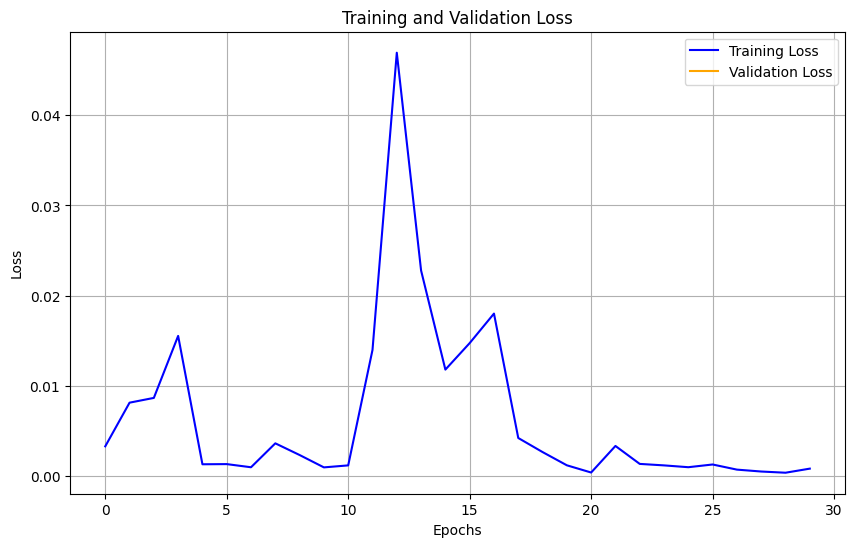

In [ ]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Evaluate on Test Set
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 556ms/step - accuracy: 0.6317 - loss: nan
Test Accuracy: 0.6126, Test Loss: nan
